# Quantum Chemistry (on my own)

In [2]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational
from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
import matplotlib.pyplot as plt
from tqdm import tqdm


In [12]:
class SpinConservation():
    
    def __init__(self,size:int):
        
        self.size=size

    def spin_conservation(self,idxs:List):

        l=len(idxs)

        total_initial_spin=0.
        for idx in idxs[:l//2]:
            
            if idx < self.size:
                total_initial_spin+=1
                
        total_final_spin=0.
        for idx in idxs[l//2:]:
            
            if idx < self.size:
                total_final_spin+=1
        return total_initial_spin==total_final_spin
    
    def local_interaction(self,idxs:List):
        
        condition=idxs[0]==idxs[-1] and idxs[1]==idxs[-2] and idxs[0]+self.size==idxs[1]
        
        return condition

In [13]:
size_a=6
size_b=6
FHHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_a,nparticles_a=3,nparticles_b=3)

u=4.
t=-1.
v_ext=np.zeros(size_a)#np.random.uniform(size=size_a)

# define the local onsite potential
twobody_matrix:Dict={}
for i in range(size_a):
    twobody_matrix[(i,i+size_a,i+size_a,i)]=u
    twobody_matrix[(i, i + size_a, i, i + size_a)] = -u
    twobody_matrix[( i + size_a,i , i + size_a,i)] = -u
    twobody_matrix[(i+size_a, i , i , i+size_a)] = u

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
for i in range(size_a):
    kinetic_term[(i,(i+1) % size_a)]=t
    kinetic_term[((i+1) % size_a,i)]=t
    
    kinetic_term[(size_a +i,size_a+(i+1) % size_a)]=t
    kinetic_term[(size_a+(i+1) % size_a,size_a +i)]=t
    
    
    # adj matrix for HF
    adj_matrix[i,(i+1)%size_a]=t
    adj_matrix[(i + 1) % size_a,i]=t
    adj_matrix[i,i]=-2*t
    adj_matrix[i+size_a,i+size_a]=-2*t
    adj_matrix[i+size_a,size_a+ (i + 1) % size_a] = t
    adj_matrix[size_a+(i + 1) % size_a,size_a+ i] = t


print(adj_matrix-adj_matrix.T)
# %%

FHHamiltonian.get_external_potential(external_potential=np.append(v_ext,v_ext))
FHHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
FHHamiltonian.get_hamiltonian()

# print(FHHamiltonian.hamiltonian)
print(FHHamiltonian.basis)
print(FHHamiltonian.hamiltonian)
# print(FHHamiltonian.twobody_operator)
# print(FHHamiltonian.kinetic_operator+FHHamiltonian.twobody_operator-FHHamiltonian.hamiltonian)
egs,psi0=FHHamiltonian.get_spectrum(n_states=1)

print(egs)


# # %% define the fit class

# HFFit = FitHartreeFock(learning_rate=0.1, epochs=200)

# history_hf = HFFit.run(HFE)
# # %%
# psi_hf = HFE.get_psi().detach().numpy()

# print(psi_hf.conjugate().transpose().dot(FHHamiltonian.hamiltonian.dot(psi_hf)))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]]
  (0, 0)	-12.0
  (0, 1)	-1.0
  (0, 12)	-1.0
  (0, 20)	-1.0
  (0, 240)	-1.0
  (1, 0)	-1.0
  (1, 1)	-8.0
  (1, 2)	-1.0
  (1, 4)	-1.0
  (1, 14)	-1.0
  (1, 21)	-1.0
  (1, 241)	-1.0
  (2, 1)	-1.0
  (2, 2)	-8.0
  (2, 3)	-1.0
  (2, 5)	-1.0
  (2, 15)	-1.0
  (2, 22)	-1.0
  (2, 242)	-1.0
  (3, 2)	-1.0
  (3, 3)	-8.0
  (3, 6)	-1.0
  (3, 23)	-1.0
  (3, 243)	-1.0
  (4, 1)	-1.0
  :	:
  (395, 398)	-1.0
  (396, 156)	-1.0
  (

In [14]:
# %% Hartree fock initialization

HFclass = HartreeFock(size=size_a, nspecies=2)

HFclass.get_hamiltonian(twobody_interaction=twobody_matrix, kinetic_term=adj_matrix,external_potential=np.append(v_ext,v_ext))

de, history_herm, ortho_history = HFclass.selfconsistent_computation(eta=1, epochs=50)

de=0.000000000000000: 100%|██████████| 50/50 [00:00<00:00, 878.56it/s]


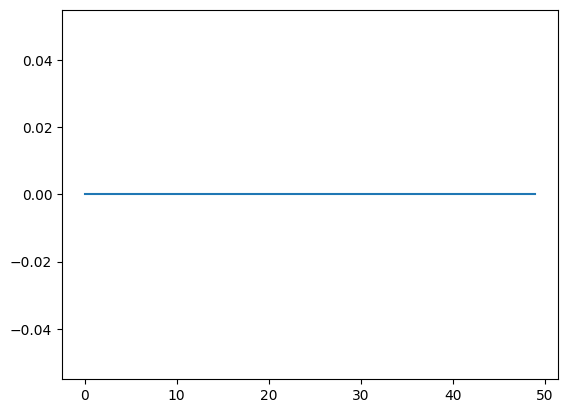

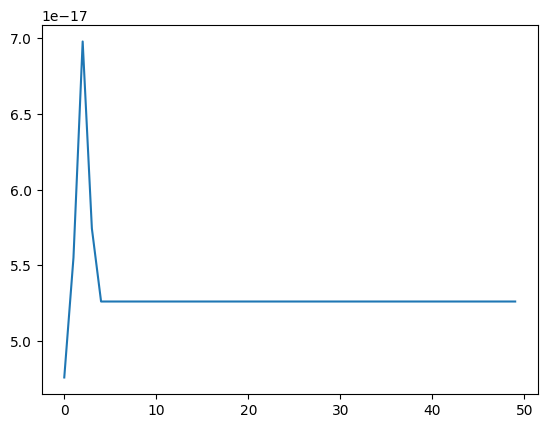

18.000000000000018


In [15]:
plt.plot(history_herm)
plt.show()

plt.plot(ortho_history)
plt.show()

energy = HFclass.compute_energy()

print(energy)

1.0
0.001772465432422654


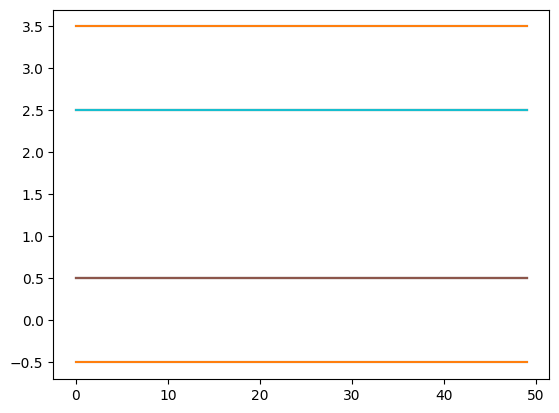

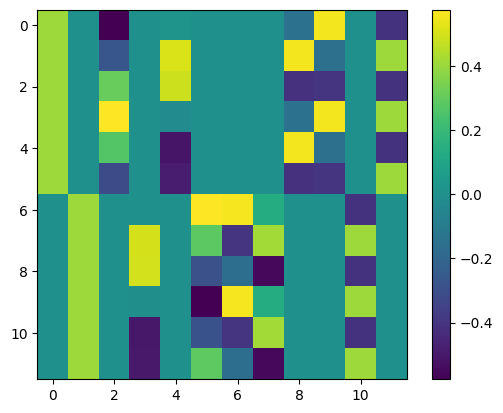

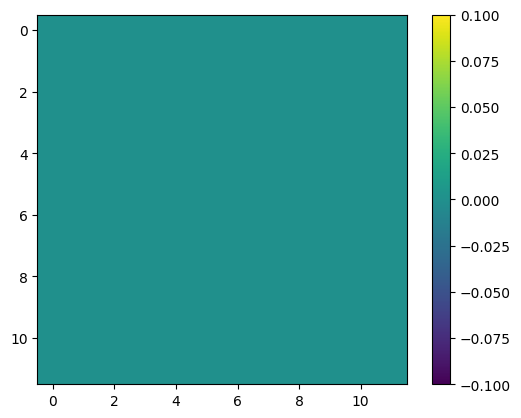

In [16]:
print(np.linalg.norm(HFclass.weights[:, 0]))
print(np.sum(HFclass.weights[0, :].conj() * HFclass.weights[:, 1]))

plt.plot(de)

# plt.semilogy()
# plt.ylim([0,0.001])
plt.show()

plt.imshow(np.real(HFclass.weights))
plt.colorbar()
plt.show()
plt.imshow(np.imag(HFclass.weights))
plt.colorbar()
plt.show()


In [17]:
psi_hf=HFclass.create_hf_psi(FHHamiltonian.basis,nparticles=6)
print(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

-14.0


In [10]:
# old initialization works better than Hartree Fock
min = 10000
for i, b in enumerate(FHHamiltonian.basis):
    psi = np.zeros(FHHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ FHHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        print(value)
        print(b)
        psi_base = psi

-3.0
[1 1 1 0 0 0 1 1 1 0 0 0]


In [19]:
spinconservation=SpinConservation(size=size_a)
operator_pool:Dict={}

operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[spinconservation.spin_conservation],nbody='two')
operator_pool=FHHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[spinconservation.spin_conservation],nbody='one')
#%%
print('number of operators=',len(list(operator_pool.keys())))

# %%
random=False

model=AdaptVQEFermiHubbard()

model.set_hamiltonian(FHHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf)

model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%


fit=Fit(method='BFGS',tolerance_opt=10**-6,e_ref=egs)

fit.configuration_checkpoint=configuration
fit.init_model(model)

#%%
history,grad_history=fit.run()
# # %%
print(model.operator_action_info)
print(model.energy-egs/egs)

number of operators= 2220


TypeError: AdaptVQEFermiHubbard.callback() takes 1 positional argument but 2 were given

In [11]:
rel_error_hf = [np.abs((e_min - egs) / egs) for e_min in history]


In [10]:
rel_error_base = [np.abs((e_min - egs) / egs) for e_min in history]

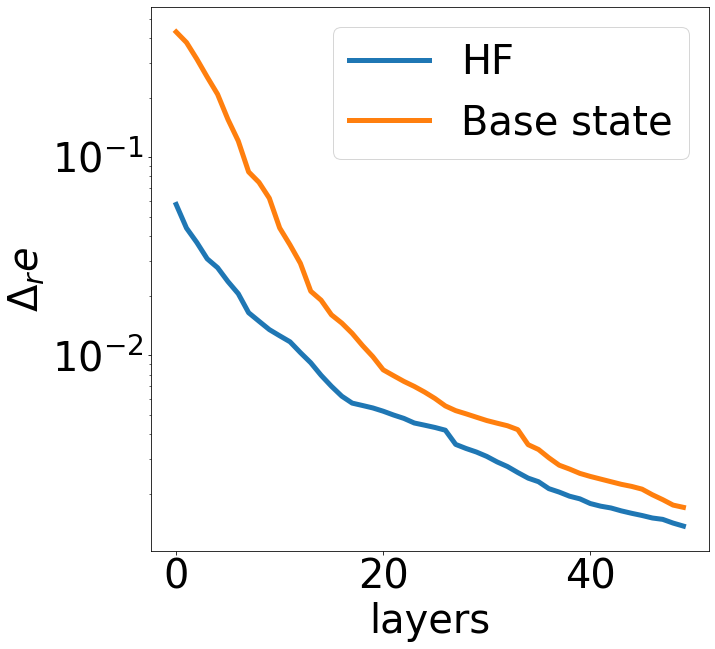

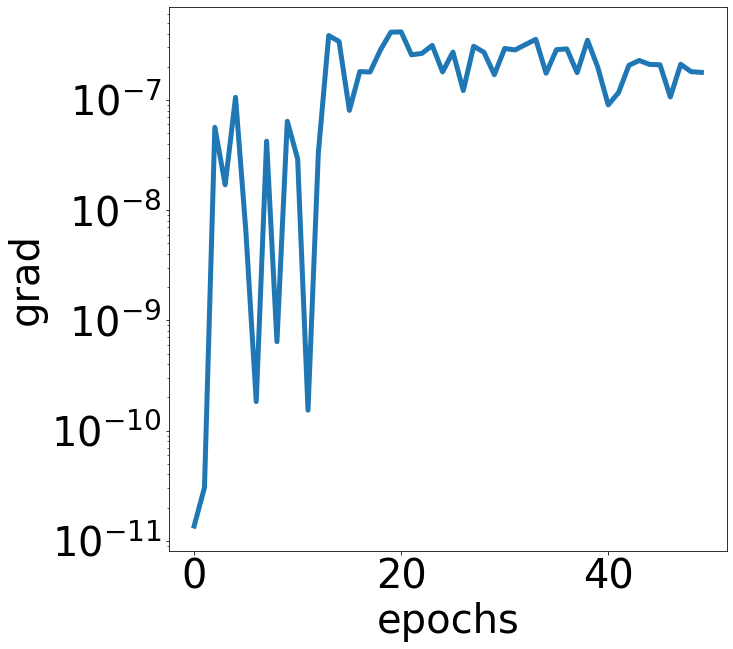

In [16]:
plt.figure(figsize=(10,10))
plt.plot(rel_error_hf,linewidth=5,label='HF')
plt.plot(rel_error_base, linewidth=5, label='Base state')
plt.xlabel('layers',fontsize=40)
plt.legend(fontsize=40)
plt.semilogy()
plt.ylabel(r'$\Delta_r e$',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.show()


plt.figure(figsize=(10,10))
plt.plot(grad_history,linewidth=5)
plt.xlabel('epochs',fontsize=40)
plt.semilogy()
plt.ylabel(r'grad',fontsize=40)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.show()

## Test Hartree Fock for different magnitude of the interaction U

In [4]:
from src.hartree_fock_library import HartreeFock, HartreeFockVariational
from src.hamiltonian_utils import (
    get_twobody_nuclearshell_model,
    FermiHubbardHamiltonian,
    SingleParticleState,
)
import numpy as np
import torch
from typing import Dict, List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
import matplotlib.pyplot as plt

In [23]:
egss=[]
e_hf=[]

t_range=tqdm(np.arange(8))
v_ext = np.random.uniform(size=size_a)

for u in t_range:

    size_a = 6
    size_b = 6
    FHHamiltonian = FermiHubbardHamiltonian(
        size_a=size_a, size_b=size_a, nparticles_a=2, nparticles_b=2
    )

    t = -1.0
    

    # define the local onsite potential
    twobody_matrix:Dict={}
    for i in range(size_a):
        twobody_matrix[(i,i+size_a,i+size_a,i)]=u
        twobody_matrix[(i, i + size_a, i, i + size_a)] = -u
        twobody_matrix[( i + size_a,i , i + size_a,i)] = -u
        twobody_matrix[(i+size_a, i , i , i+size_a)] = u

    kinetic_term:Dict={}
    adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
    for i in range(size_a):
        kinetic_term[(i,(i+1) % size_a)]=t
        kinetic_term[((i+1) % size_a,i)]=t
        
        kinetic_term[(size_a +i,size_a+(i+1) % size_a)]=t
        kinetic_term[(size_a+(i+1) % size_a,size_a +i)]=t
        
        
        # adj matrix for HF
        adj_matrix[i,(i+1)%size_a]=t
        adj_matrix[(i + 1) % size_a,i]=t
        adj_matrix[i,i]=-2*t
        adj_matrix[i+size_a,i+size_a]=-2*t
        adj_matrix[i+size_a,size_a+ (i + 1) % size_a] = t
        adj_matrix[size_a+(i + 1) % size_a,size_a+ i] = t

    print(adj_matrix - adj_matrix.T)
    # %%

    FHHamiltonian.get_external_potential(external_potential=np.append(v_ext, v_ext))
    FHHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
    FHHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
    FHHamiltonian.get_hamiltonian()

    # print(FHHamiltonian.hamiltonian)
    print(FHHamiltonian.hamiltonian)
    # print(FHHamiltonian.twobody_operator)
    # print(FHHamiltonian.kinetic_operator+FHHamiltonian.twobody_operator-FHHamiltonian.hamiltonian)
    egs, psi0 = FHHamiltonian.get_spectrum(n_states=1)

    print(egs)
    egss.append(egs)

    # %% Hartree fock initialization

    HFclass = HartreeFock(size=size_a, nspecies=2)

    HFclass.get_hamiltonian(
        twobody_interaction=twobody_matrix,
        kinetic_term=adj_matrix,
        external_potential=np.append(v_ext, v_ext),
    )

    de, history_herm, ortho_history = HFclass.selfconsistent_computation(eta=1, epochs=50)

    psi_hf = HFclass.create_hf_psi(FHHamiltonian.basis, nparticles=4)
    print(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

    e_hf.append(psi_hf.conjugate().transpose() @ FHHamiltonian.hamiltonian @ psi_hf)

  0%|          | 0/8 [00:00<?, ?it/s]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	1.5701825978640471
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	1.6313223094114457
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	1.2927693703520005
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	1.1914746452050533
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	1.0
  (221, 221)	1.62

 12%|█▎        | 1/8 [00:00<00:02,  2.98it/s]

-4.767387172958671
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-0.4298174021359529
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	0.6313223094114457
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	0.29276937035200046
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	0.1914746452050533
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	

 25%|██▌       | 2/8 [00:00<00:01,  3.02it/s]

-5.5410522137753775
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-2.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-0.36867769058855426
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-0.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-0.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 22

 38%|███▊      | 3/8 [00:00<00:01,  3.12it/s]

-6.314717254592087
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-4.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-1.3686776905885543
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-1.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-1.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)

 50%|█████     | 4/8 [00:01<00:01,  3.19it/s]

-7.088382295408795
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-6.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-2.3686776905885543
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-2.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-2.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)

 62%|██████▎   | 5/8 [00:01<00:00,  3.10it/s]

-7.862047336225506
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-8.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-3.3686776905885543
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-3.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-3.8085253547949467
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)

 75%|███████▌  | 6/8 [00:01<00:00,  3.14it/s]

-8.635712377042212
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-10.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-4.368677690588554
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-4.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-4.808525354794947
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	

 88%|████████▊ | 7/8 [00:02<00:00,  2.99it/s]

-9.409377417858922
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
  (0, 0)	-12.429817402135953
  (0, 1)	1.0
  (0, 8)	-1.0
  (0, 15)	1.0
  (0, 120)	-1.0
  (1, 0)	1.0
  (1, 1)	-5.368677690588554
  (1, 2)	1.0
  (1, 5)	1.0
  (1, 11)	-1.0
  (1, 16)	1.0
  (1, 121)	-1.0
  (2, 1)	1.0
  (2, 2)	-5.7072306296479995
  (2, 3)	1.0
  (2, 6)	1.0
  (2, 13)	-1.0
  (2, 17)	1.0
  (2, 122)	-1.0
  (3, 2)	1.0
  (3, 3)	-5.808525354794947
  (3, 4)	1.0
  (3, 7)	1.0
  (3, 14)	-1.0
  (3, 18)	1.0
  :	:
  (220, 222)	1.0
  (221, 56)	-1.0
  (221, 206)	1.0
  (221, 211)	-1.0
  (221, 218)	1.0
  (221, 220)	

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

-10.18304245867563


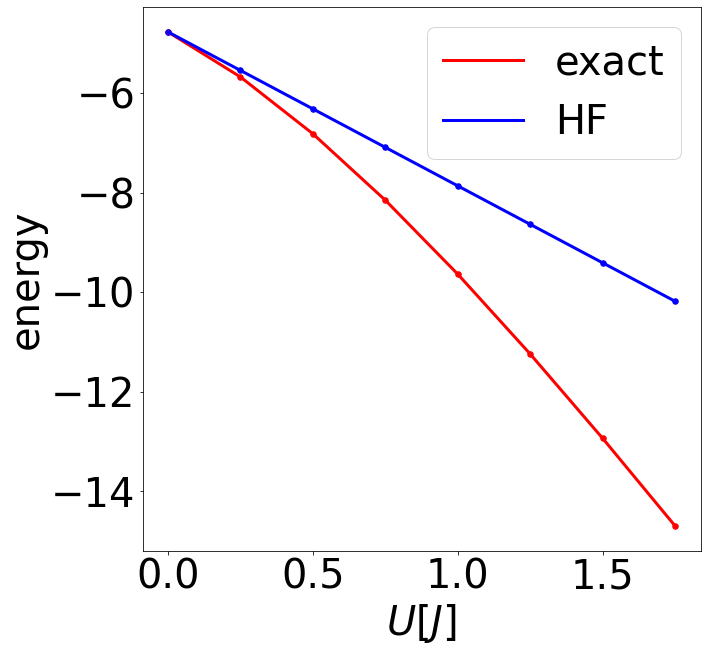

In [26]:
u=np.arange(8)/4
plt.figure(figsize=(10,10))
plt.plot(u,egss,color='red',linewidth=3,label='exact')
plt.scatter(u, egss, color="red", s=30)

plt.plot(u, e_hf, color="blue", linewidth=3,label='HF')
plt.scatter(u, e_hf, color="blue", s=30)
plt.tick_params(which='major',labelsize=40)
plt.xlabel(r'$U [J]$',fontsize=40)
plt.ylabel("energy", fontsize=40)
plt.legend(fontsize=40)
plt.show()

# Quantum Chemistry with Qiskit

In [1]:



from math import pi

import numpy as np
import rustworkx as rx
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper,ParityMapper
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.problems import LatticeModelProblem


#### Create a Fermi-Hubbard Hamiltonian

Lattice

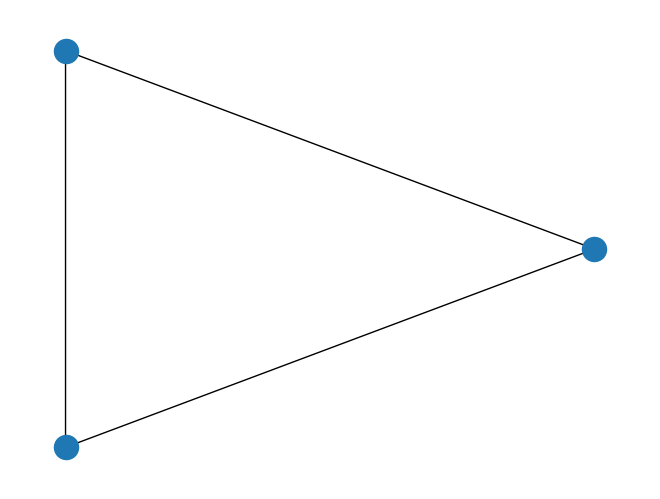

In [2]:
sites=3
boundary_condition = (
    BoundaryCondition.PERIODIC,
)  # open in the x-direction, periodic in the y-direction
#square_lattice = SquareLattice(rows=rows, cols=cols, boundary_condition=boundary_condition)
line_lattice=LineLattice(num_nodes=sites,boundary_condition=boundary_condition)

line_lattice.draw()

Hamiltonian


In [6]:

t = -1.0  # the interaction parameter
v = 0.0  # the onsite potential
u = 5.0  # the interaction parameter U
n_up=2
n_down=2

fhm = FermiHubbardModel(
    line_lattice.uniform_parameters(
        uniform_interaction=t,
        uniform_onsite_potential=v,
    ),
    onsite_interaction=0,
)

ham = fhm.second_q_op()
print(ham.to_matrix)
lmp = LatticeModelProblem(fhm)



AttributeError: 'FermionicOp' object has no attribute 'to_matrix'

#### Get the GS fixing the number of particles

In [4]:
mapper = ParityMapper(num_particles=(1,0))
#mapper=JordanWignerMapper()
qubit_hamiltonian = mapper.map(ham)
print(qubit_hamiltonian)

solver=NumPyMinimumEigensolver()

res=solver.compute_minimum_eigenvalue(qubit_hamiltonian)
print(res)


SparsePauliOp(['IIXX', 'IIYY', 'ZXZI', 'IYII', 'ZXXX', 'IYXY', 'IZXZ', 'IIYI', 'XXII', 'YYII', 'XXXZ', 'YXYI'],
              coeffs=[-0.5+0.j,  0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])
{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([-0.28810567-0.00998194j,  0.07200559-0.05119526j,
             -0.07384583+0.04496393j, -0.34481116+0.02599262j,
             -0.42226967+0.25150145j, -0.06209862-0.03458295j,
              0.07350639+0.07792364j, -0.12703801+0.22993249j,
              0.34405116-0.18415676j,  0.02092468+0.09510427j,
              0.24457032-0.18854034j,  0.12237185-0.18005488j,
             -0.1714768 +0.02282804j, -0.226052  +0.02648263j,
              0.13578329-0.04345119j, -0.21164062+0.0598099j ],
            dims=(2, 2, 2, 2)),
    'eigenvalue': -3.043622485320761}
